### SIR

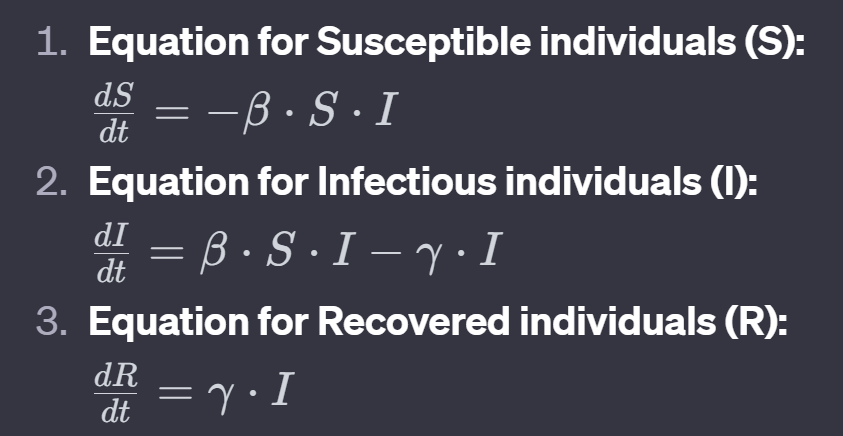

Date
1/20/20      0
1/21/20      0
1/22/20      0
1/23/20      2
1/24/20      2
1/25/20      2
1/26/20      2
1/27/20      3
1/28/20      3
1/29/20      4
1/30/20      4
1/31/20      4
2/1/20       5
2/2/20       5
2/3/20      10
2/4/20      13
2/5/20      16
2/6/20      22
2/7/20      31
2/8/20      39
2/9/20      46
2/10/20     56
2/11/20     66
2/12/20     82
2/13/20     94
2/14/20    104
2/15/20    115
2/16/20    131
2/17/20    152
2/18/20    163
2/19/20    182
2/20/20    199
2/21/20    222
2/22/20    226
2/23/20    237
2/24/20    249
2/25/20    262
2/26/20    271
2/27/20    281
2/28/20    281
2/29/20    299
3/1/20     308
3/2/20     320
3/3/20     332
3/4/20     341
3/5/20     350
3/6/20     358
3/7/20     361
3/8/20     368
3/9/20     373
Name: cummulative cured cases, dtype: int64
Date
1/20/20    0
1/21/20    0
1/22/20    0
1/23/20    0
1/24/20    0
1/25/20    0
1/26/20    0
1/27/20    0
1/28/20    0
1/29/20    0
1/30/20    0
1/31/20    0
2/1/20     0
2/2/20     0
2/3/20     0
2

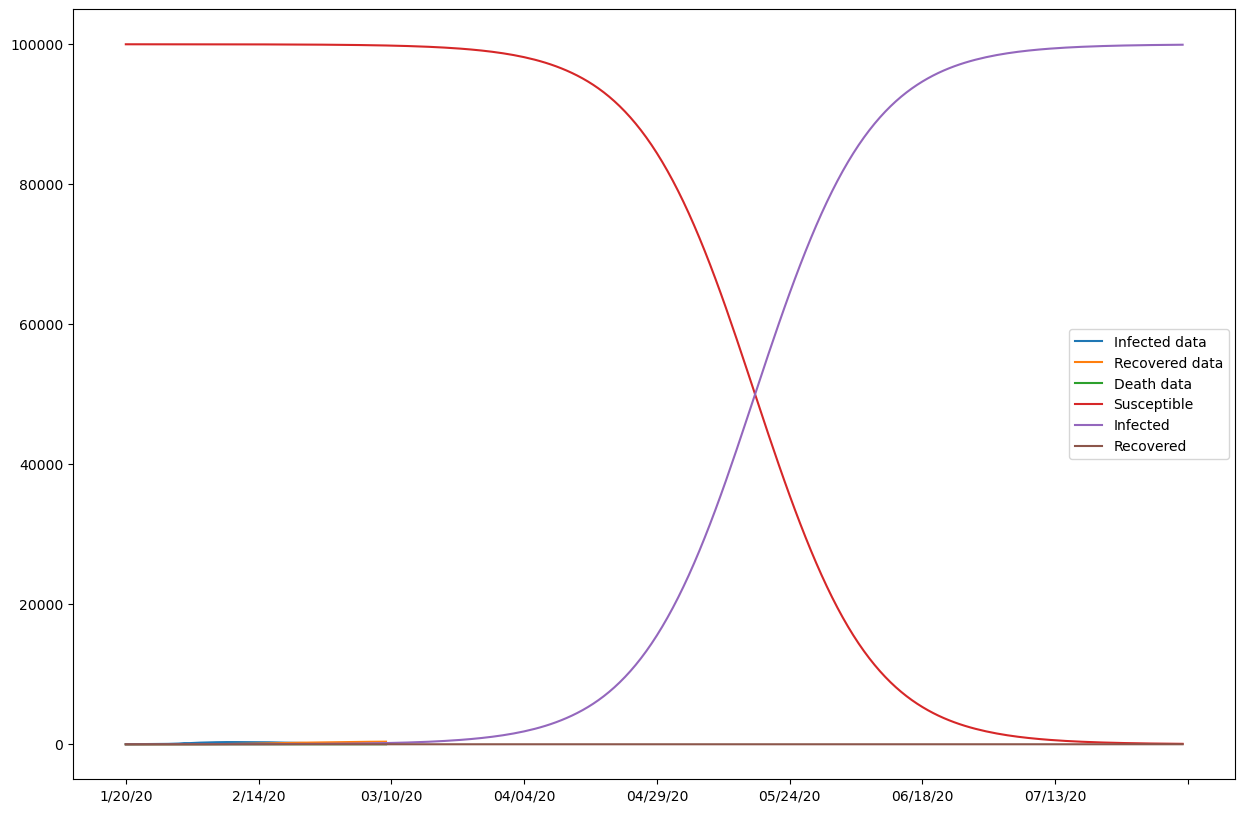

In [2]:
#!/usr/bin/python
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

predict_range = 200
s_0=99998
i_0=2
r_0=0
class Learner(object):
    def __init__(self, loss, predict_range, s_0, i_0, r_0):
        self.loss = loss
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0
    def load_confirmed(self):
      df = pd.read_csv('02_SZ_DailyCases.csv')
      df.set_index(["Date"], inplace=True)
      dff=df["cummulative confirmed cases"]
      print(dff.T)
      return dff.T

    def load_recovered(self):
        df = pd.read_csv('02_SZ_DailyCases.csv')
        df.set_index(["Date"], inplace=True)
        dff = df["cummulative cured cases"]
        print(dff.T)
        return dff.T

    def load_dead(self):
        df = pd.read_csv('02_SZ_DailyCases.csv')
        df.set_index(["Date"], inplace=True)
        dff = df["cummulative dead cases"]
        print(dff.T)
        return dff.T

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data, recovered, death, s_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)

        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta * S * I, beta * S * I - gamma * I, gamma * I]

        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        return new_index, extended_actual, extended_recovered, extended_death, solve_ivp(SIR, [0, size],
                                                                                         [s_0, i_0, r_0],
                                                                                         t_eval=np.arange(0, size, 1))

    def train(self):
        recovered = self.load_recovered()
        death = self.load_dead()
        data = (self.load_confirmed() - recovered - death)

        optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, self.s_0, self.i_0, self.r_0),
                           method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
        print(optimal)
        beta, gamma = optimal.x
        new_index, extended_actual, extended_recovered, extended_death, prediction = self.predict(beta, gamma, data,
                                                                                                  recovered, death,

                                                                                                  self.s_0, self.i_0,
                                                                                                  self.r_0)
        df = pd.DataFrame(
            {'Infected data': extended_actual, 'Recovered data': extended_recovered, 'Death data': extended_death,
             'Susceptible': prediction.y[0], 'Infected': prediction.y[1], 'Recovered': prediction.y[2]},
            index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        # df.to_csv("result_SIR.csv")
        #ax.set_title(self.country)
        df.plot(ax=ax)
        print(f" beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta / gamma):.8f}")
        # fig.savefig("result_SIR.png")


def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point

    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta * S * I, beta * S * I - gamma * I, gamma * I]

    # Here
    # solution = odeint(SIR, [0, size], [s_0, i_0, r_0])
    solution = solve_ivp(SIR, [0, size], [s_0, i_0, r_0], t_eval=np.arange(0, size, 1), vectorized=True)

    l1 = np.sqrt(np.mean((solution.y[1] - data) ** 2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered) ** 2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2


def main():
    learner = Learner(loss, predict_range, s_0, i_0, r_0)
    learner.train()


if __name__ == '__main__':
    main()

### SIR model with stochasticity
sigma=0.1

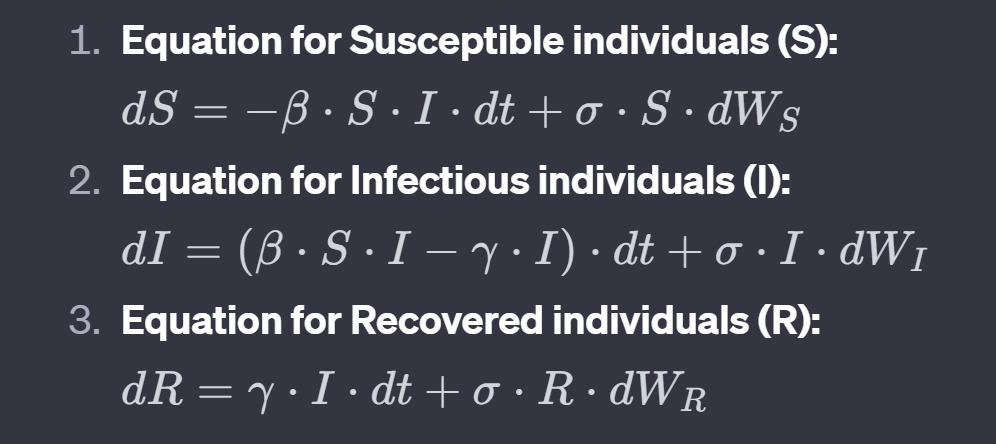

S, I, and R represent the numbers of susceptible, infectious, and recovered individuals, respectively.

β is the transmission rate, representing the probability of transmission between a susceptible and an infectious individual.

γ is the recovery rate, representing the fraction of infectious individuals recovering per unit of time.

dt is the time step for the Euler-Maruyama method, and σ is the standard deviation of the stochastic terms.

Date
1/20/20      0
1/21/20      0
1/22/20      0
1/23/20      2
1/24/20      2
1/25/20      2
1/26/20      2
1/27/20      3
1/28/20      3
1/29/20      4
1/30/20      4
1/31/20      4
2/1/20       5
2/2/20       5
2/3/20      10
2/4/20      13
2/5/20      16
2/6/20      22
2/7/20      31
2/8/20      39
2/9/20      46
2/10/20     56
2/11/20     66
2/12/20     82
2/13/20     94
2/14/20    104
2/15/20    115
2/16/20    131
2/17/20    152
2/18/20    163
2/19/20    182
2/20/20    199
2/21/20    222
2/22/20    226
2/23/20    237
2/24/20    249
2/25/20    262
2/26/20    271
2/27/20    281
2/28/20    281
2/29/20    299
3/1/20     308
3/2/20     320
3/3/20     332
3/4/20     341
3/5/20     350
3/6/20     358
3/7/20     361
3/8/20     368
3/9/20     373
Name: cummulative cured cases, dtype: int64
Date
1/20/20    0
1/21/20    0
1/22/20    0
1/23/20    0
1/24/20    0
1/25/20    0
1/26/20    0
1/27/20    0
1/28/20    0
1/29/20    0
1/30/20    0
1/31/20    0
2/1/20     0
2/2/20     0
2/3/20     0
2

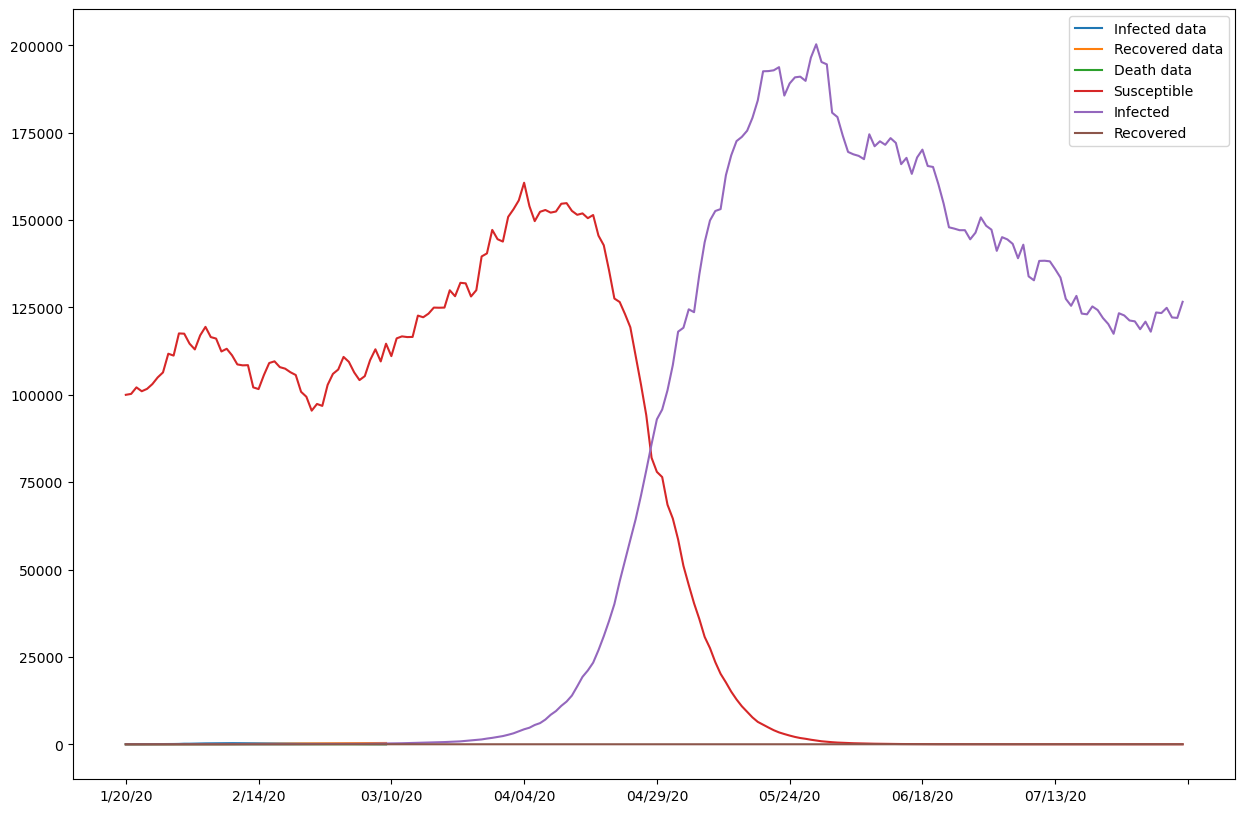

In [1]:
#!/usr/bin/python
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
np.random.seed(42)  # for reproducibility
predict_range = 200
s_0=99998
i_0=2
r_0=0
class Learner(object):
    def __init__(self, loss, predict_range, s_0, i_0, r_0):
        self.loss = loss
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0
    def load_confirmed(self):
      df = pd.read_csv('02_SZ_DailyCases.csv')
      df.set_index(["Date"], inplace=True)
      dff=df["cummulative confirmed cases"]
      print(dff.T)
      return dff.T

    def load_recovered(self):
        df = pd.read_csv('02_SZ_DailyCases.csv')
        df.set_index(["Date"], inplace=True)
        dff = df["cummulative cured cases"]
        print(dff.T)
        return dff.T

    def load_dead(self):
        df = pd.read_csv('02_SZ_DailyCases.csv')
        df.set_index(["Date"], inplace=True)
        dff = df["cummulative dead cases"]
        print(dff.T)
        return dff.T

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data, recovered, death, s_0, i_0, r_0, sigma=0.1):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)

        def SIR_stochastic(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            dS = -beta * S * I * dt + sigma * S * np.sqrt(dt) * np.random.normal()
            dI = (beta * S * I - gamma * I) * dt + sigma * I * np.sqrt(dt) * np.random.normal()
            dR = gamma * I * dt + sigma * R * np.sqrt(dt) * np.random.normal()
            return [dS, dI, dR]

        dt = 1.0  # time step for Euler-Maruyama method

        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        result = solve_ivp(SIR_stochastic, [0, size], [s_0, i_0, r_0], t_eval=np.arange(0, size, 1))

        return new_index, extended_actual, extended_recovered, extended_death, result

    def train(self):
        recovered = self.load_recovered()
        death = self.load_dead()
        data = (self.load_confirmed() - recovered - death)

        optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, self.s_0, self.i_0, self.r_0),
                           method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
        print(optimal)
        beta, gamma = optimal.x
        new_index, extended_actual, extended_recovered, extended_death, prediction = self.predict(beta, gamma, data,
                                                                                                  recovered, death,

                                                                                                  self.s_0, self.i_0,
                                                                                                  self.r_0)
        df = pd.DataFrame(
            {'Infected data': extended_actual, 'Recovered data': extended_recovered, 'Death data': extended_death,
             'Susceptible': prediction.y[0], 'Infected': prediction.y[1], 'Recovered': prediction.y[2]},
            index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        # df.to_csv("result_SIR.csv")
        df.plot(ax=ax)
        print(f" beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta / gamma):.8f}")
        fig.savefig("result_SIR.png")


def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point

    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta * S * I, beta * S * I - gamma * I, gamma * I]

    # Here
    # solution = odeint(SIR, [0, size], [s_0, i_0, r_0])
    solution = solve_ivp(SIR, [0, size], [s_0, i_0, r_0], t_eval=np.arange(0, size, 1), vectorized=True)

    l1 = np.sqrt(np.mean((solution.y[1] - data) ** 2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered) ** 2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2


def main():
    learner = Learner(loss, predict_range, s_0, i_0, r_0)
    learner.train()


if __name__ == '__main__':
    main()

### SEIR

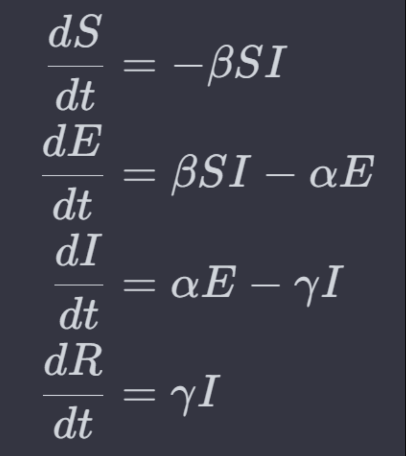

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 53.220535007185276
        x: [ 5.271e-06  3.628e-01  4.000e-01]
      nit: 39
      jac: [-1.768e+07 -1.084e+02  2.164e+02]
     nfev: 392
     njev: 98
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
 beta=0.00000527, alpha=0.36275068, gamma=0.40000000, r_0:0.00001318
         Infected data Recovered data Death data   Susceptible    Exposed  \
1/20/20            4.5              0          0  99990.000000   8.000000   
1/21/20            7.0              0          0  99988.501134   6.843176   
1/22/20            7.5              0          0  99986.411187   6.524655   
1/23/20            5.5              2          0  99983.977699   6.587238   
1/24/20            8.0              2          0  99981.304242   6.831414   
...                ...            ...        ...           ...        ...   
09/21/20          None           None       None  56039.139807  11.277187   
09/22/

C:\Users\19hmz\AppData\Local\Temp\ipykernel_26500\1403928472.py:100: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


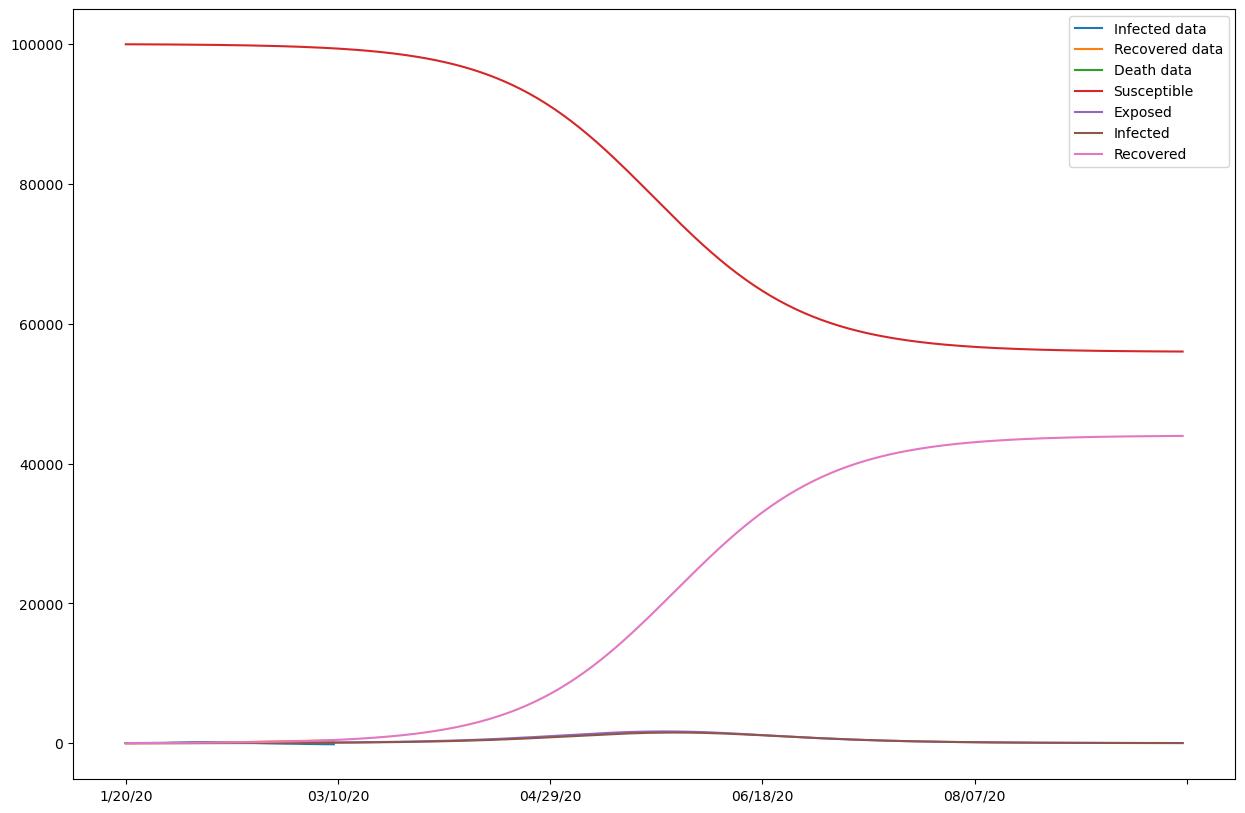

In [13]:
#!/usr/bin/python
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

predict_range = 250
s_0=99990
e_0=8
i_0=2
r_0=0
ratio=0.5

class Learner(object):
    def __init__(self, loss, predict_range, s_0, e_0,i_0, r_0):
        self.loss = loss
        self.predict_range = predict_range
        self.s_0 = s_0
        self.e_0 = e_0
        self.i_0 = i_0
        self.r_0 = r_0

    def load_confirmed(self):
        df = pd.read_csv('02_SZ_DailyCases.csv')
        df.set_index(["Date"], inplace=True)
        dff=df["cummulative confirmed cases"]
        return dff.T

    def load_exposed(self,ratio):
        df = pd.read_csv('02_SZ_DailyCases.csv')
        df.set_index(["Date"], inplace=True)
        dff=df["cummulative confirmed cases"]
        dfff=dff*ratio
        return dfff.T


    def load_recovered(self):
        df = pd.read_csv('02_SZ_DailyCases.csv')
        df.set_index(["Date"], inplace=True)
        dff = df["cummulative cured cases"]
        return dff.T

    def load_dead(self):
        df = pd.read_csv('02_SZ_DailyCases.csv')
        df.set_index(["Date"], inplace=True)
        dff = df["cummulative dead cases"]
        return dff.T

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, alpha, gamma, data, exposed, recovered, death, s_0, e_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)

        def SEIR(t, y):
            S = y[0]
            E = y[1]
            I = y[2]
            R = y[3]
            return [-beta * S * I, beta * S * I - alpha* E, alpha* E- gamma * I, gamma * I]

        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_exposed = np.concatenate((exposed.values, [None] * (size - len(exposed.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        return new_index, extended_actual, extended_exposed, extended_recovered, extended_death, solve_ivp(SEIR,[0, size],
                                                                                         [s_0, e_0,i_0, r_0],
                                                                                         t_eval=np.arange(0, size, 1))

    def train(self):
        recovered = self.load_recovered()
        exposed = self.load_exposed(ratio)
        death = self.load_dead()
        data = (self.load_confirmed() - exposed - recovered - death)#易感人数

        optimal = minimize(loss, [0.001, 0.001, 0.001], args=(data, exposed, recovered, self.s_0, self.e_0, self.i_0, self.r_0),
                           method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4), (0.00000001, 0.4)])
        print(optimal)
        beta, alpha, gamma = optimal.x
        new_index, extended_actual, extended_exposed, extended_recovered, extended_death, prediction = self.predict(beta, alpha, gamma, data, exposed, recovered, death,

                                                                                                  self.s_0, self.e_0,self.i_0,
                                                                                                  self.r_0)
        df = pd.DataFrame(
            {'Infected data': extended_actual, 'Recovered data': extended_recovered, 'Death data': extended_death,
             'Susceptible': prediction.y[0], 'Exposed': prediction.y[1], 'Infected': prediction.y[2], 'Recovered': prediction.y[3]},
            index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        #ax.set_title(self.country)
        df.plot(ax=ax)
        print(f" beta={beta:.8f}, alpha={alpha:.8f}, gamma={gamma:.8f}, r_0:{(beta / gamma):.8f}")
        fig.show()
        print(df)


def loss(point, data, exposed, recovered, s_0, e_0, i_0, r_0):
    size = len(data)
    beta, alpha, gamma = point

    def SEIR(t, y):
        S = y[0]
        E = y[1]
        I = y[2]
        R = y[3]
        return [-beta * S * I, beta * S * I - alpha * E, alpha * E - gamma * I, gamma * I]

    solution = solve_ivp(SEIR, [0, size], [s_0, e_0, i_0, r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data) ** 2))
    l2 = np.sqrt(np.mean((solution.y[2] - exposed) ** 2))
    l3 = np.sqrt(np.mean((solution.y[3] - recovered) ** 2))
    a1 = 0.1
    a2 = 0.1
    return a1 * l1 + a2 * l2 + (1 - a1 - a2) * l3


def main():
    learner = Learner(loss, predict_range, s_0, e_0, i_0, r_0)
    learner.train()


if __name__ == '__main__':
    main()

### SEIR model with stochasticity
sigma=0.1

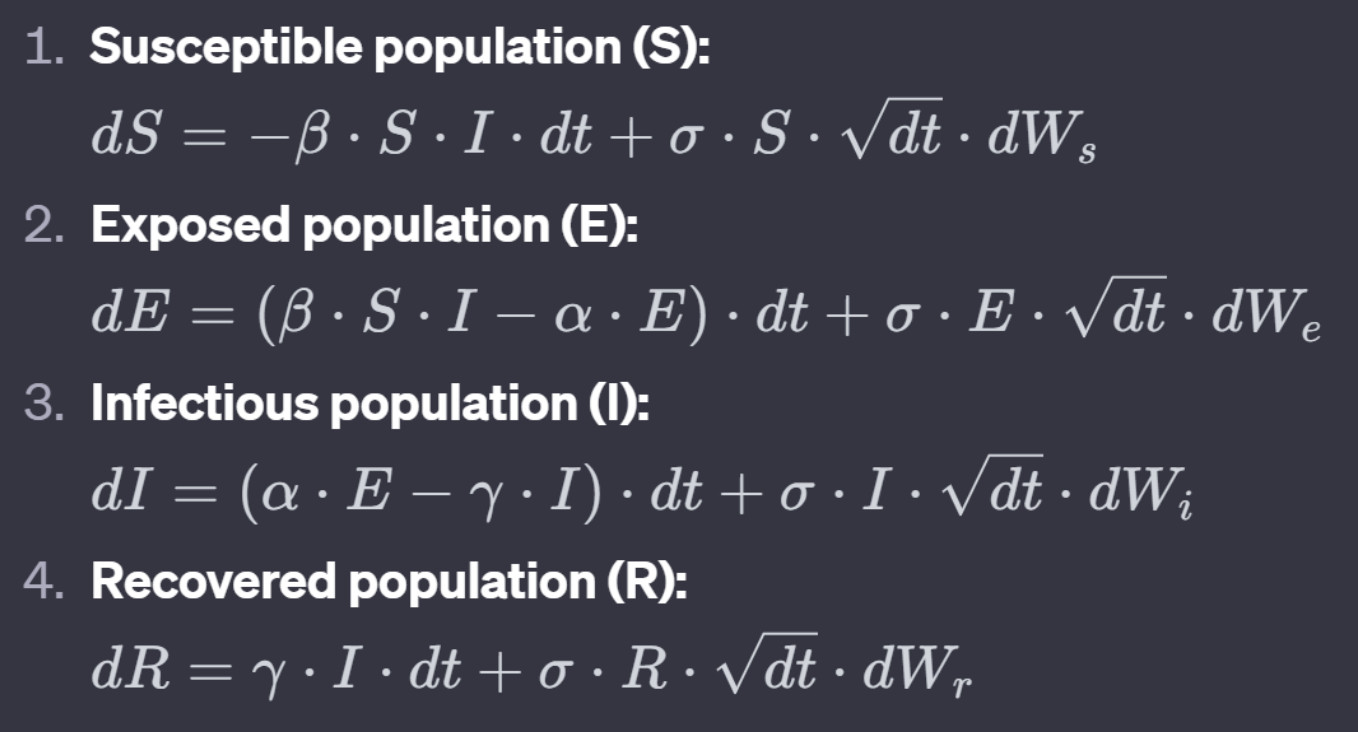

Here,

S is the susceptible population,

E is the exposed population (infected but not yet infectious),

I is the infectious population,

R is the recovered population,

β is the transmission rate,

α is the rate of progression from exposed to infectious,

γ is the recovery rate,

dt is the time step for the Euler-Maruyama method,

σ is the volatility parameter controlling the magnitude of the noise.

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 53.220535007185276
        x: [ 5.271e-06  3.628e-01  4.000e-01]
      nit: 39
      jac: [-1.768e+07 -1.084e+02  2.164e+02]
     nfev: 392
     njev: 98
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
 beta=0.00000527, alpha=0.36275068, gamma=0.40000000, r_0:0.00001318
         Infected data Recovered data Death data    Susceptible   Exposed  \
1/20/20            4.5              0          0   99990.000000  8.000000   
1/21/20            7.0              0          0   95769.384976  6.852069   
1/22/20            7.5              0          0   96228.499187  6.643949   
1/23/20            5.5              2          0  101955.758664  7.008313   
1/24/20            8.0              2          0  103640.124872  7.024544   
...                ...            ...        ...            ...       ...   
09/21/20          None           None       None   54099.568096  0.942981   
09/22/

C:\Users\19hmz\AppData\Local\Temp\ipykernel_26500\1649213809.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


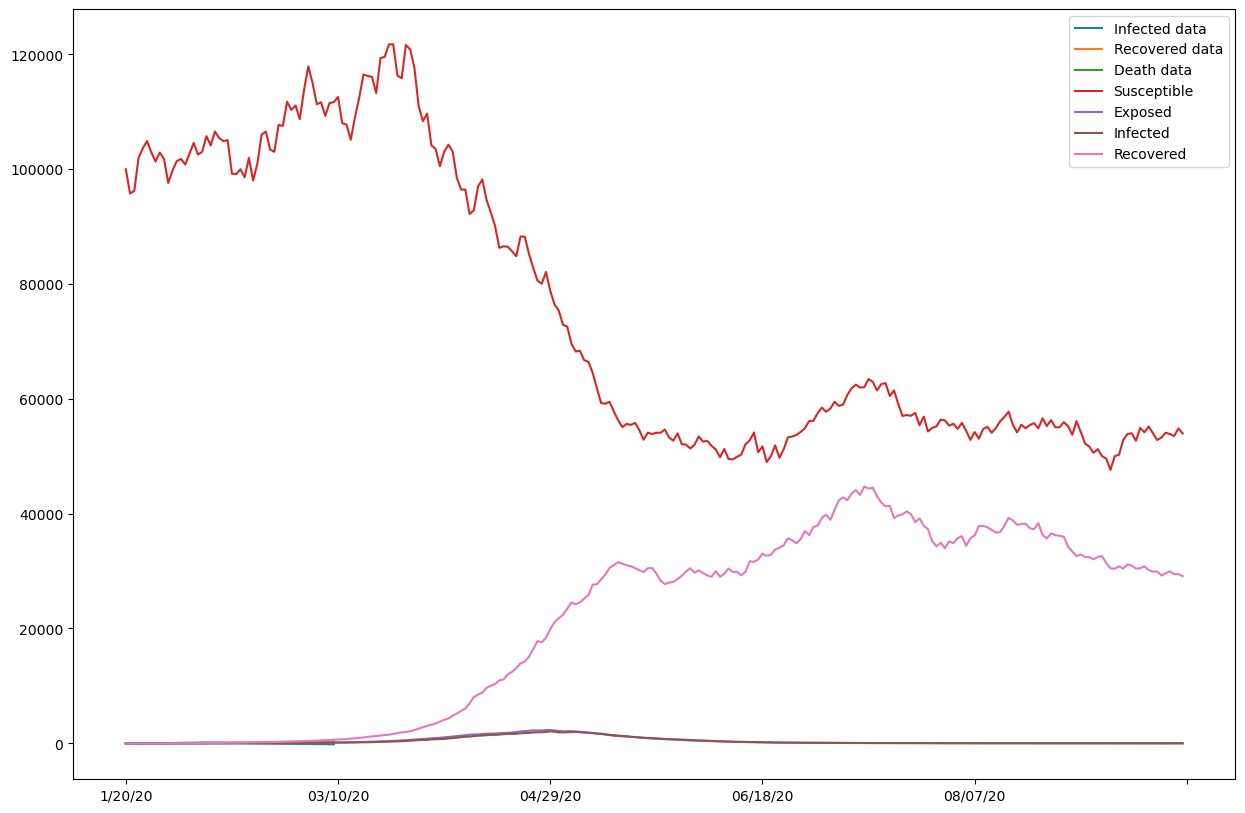

In [14]:
#!/usr/bin/python
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

np.random.seed(42)  # for reproducibility

predict_range = 250
s_0 = 99990
e_0 = 8
i_0 = 2
r_0 = 0
ratio = 0.5

class Learner(object):
    def __init__(self, loss, predict_range, s_0, e_0, i_0, r_0):
        self.loss = loss
        self.predict_range = predict_range
        self.s_0 = s_0
        self.e_0 = e_0
        self.i_0 = i_0
        self.r_0 = r_0

    def load_confirmed(self):
        df = pd.read_csv('02_SZ_DailyCases.csv')
        df.set_index(["Date"], inplace=True)
        dff = df["cummulative confirmed cases"]
        return dff.T

    def load_exposed(self, ratio):
        df = pd.read_csv('02_SZ_DailyCases.csv')
        df.set_index(["Date"], inplace=True)
        dff = df["cummulative confirmed cases"]
        dfff = dff * ratio
        return dfff.T

    def load_recovered(self):
        df = pd.read_csv('02_SZ_DailyCases.csv')
        df.set_index(["Date"], inplace=True)
        dff = df["cummulative cured cases"]
        return dff.T

    def load_dead(self):
        df = pd.read_csv('02_SZ_DailyCases.csv')
        df.set_index(["Date"], inplace=True)
        dff = df["cummulative dead cases"]
        return dff.T

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, alpha, gamma, data, exposed, recovered, death, s_0, e_0, i_0, r_0, sigma=0.1):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)

        dt = 1.0  # time step for Euler-Maruyama method

        def SEIR_stochastic(t, y):
            S = y[0]
            E = y[1]
            I = y[2]
            R = y[3]
            dS = -beta * S * I * dt + sigma * S * np.sqrt(dt) * np.random.normal()
            dE = (beta * S * I - alpha * E) * dt + sigma * E * np.sqrt(dt) * np.random.normal()
            dI = (alpha * E - gamma * I) * dt + sigma * I * np.sqrt(dt) * np.random.normal()
            dR = gamma * I * dt + sigma * R * np.sqrt(dt) * np.random.normal()
            return [dS, dE, dI, dR]

        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_exposed = np.concatenate((exposed.values, [None] * (size - len(exposed.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        result = solve_ivp(SEIR_stochastic, [0, size], [s_0, e_0, i_0, r_0], t_eval=np.arange(0, size, 1))

        return new_index, extended_actual, extended_exposed, extended_recovered, extended_death, result

    def train(self):
        recovered = self.load_recovered()
        exposed = self.load_exposed(ratio)
        death = self.load_dead()
        data = (self.load_confirmed() - exposed - recovered - death)

        optimal = minimize(loss, [0.001, 0.001, 0.001], args=(data, exposed, recovered, self.s_0, self.e_0, self.i_0, self.r_0),
                           method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4), (0.00000001, 0.4)])
        print(optimal)
        beta, alpha, gamma = optimal.x
        new_index, extended_actual, extended_exposed, extended_recovered, extended_death, prediction = self.predict(
            beta, alpha, gamma, data, exposed, recovered, death,
            self.s_0, self.e_0, self.i_0, self.r_0)
        df = pd.DataFrame(
            {'Infected data': extended_actual, 'Recovered data': extended_recovered, 'Death data': extended_death,
             'Susceptible': prediction.y[0], 'Exposed': prediction.y[1], 'Infected': prediction.y[2],
             'Recovered': prediction.y[3]},
            index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        df.plot(ax=ax)
        print(f" beta={beta:.8f}, alpha={alpha:.8f}, gamma={gamma:.8f}, r_0:{(beta / gamma):.8f}")
        fig.show()
        print(df)

def loss(point, data, exposed, recovered, s_0, e_0, i_0, r_0):
    size = len(data)
    beta, alpha, gamma = point

    def SEIR(t, y):
        S = y[0]
        E = y[1]
        I = y[2]
        R = y[3]
        return [-beta * S * I, beta * S * I - alpha * E, alpha * E - gamma * I, gamma * I]

    dt = 1.0
    solution = solve_ivp(SEIR, [0, size], [s_0, e_0, i_0, r_0], t_eval=np.arange(0, size, 1))
    l1 = np.sqrt(np.mean((solution.y[1] - data) ** 2))
    l2 = np.sqrt(np.mean((solution.y[2] - exposed) ** 2))
    l3 = np.sqrt(np.mean((solution.y[3] - recovered) ** 2))
    a1 = 0.1
    a2 = 0.1
    return a1 * l1 + a2 * l2 + (1 - a1 - a2) * l3

def main():
    learner = Learner(loss, predict_range, s_0, e_0, i_0, r_0)
    learner.train()

if __name__ == '__main__':
    main()


### The equilibrium point in SEIR 

Equilibrium points and asymptotic behavior analysis are crucial for understanding the long-term trends of epidemic models. In the SEIR model, equilibrium points refer to states where the populations of different compartments stabilize over an extended period. These points are determined by setting the derivatives to zero.

Equilibrium points occur when the derivatives are zero, i.e., 
dS/dt=dE/dt=dI/dt=dR/dt=0. Solving this system of equations yields the equilibrium points.

For asymptotic behavior analysis, we can gain insights into the disease spread trends by examining the values of model parameters, namely β, α, and γ. Key observations include:

R0 Value: R0=γ/β, indicating the average number of people infected by each case. If R0<1, the disease tends to disappear; if R0>1, the disease tends to spread.

Stages of Disease Spread: Analysis of different stages of disease spread based on parameter values. For instance, initial stages may involve exponential growth, followed by logarithmic growth, ultimately stabilizing.

Infection and Recovery Ratio: The ratio α/γ influences the relative duration of the exposed and infected periods, with a longer incubation period potentially leading to an extended duration of transmission.

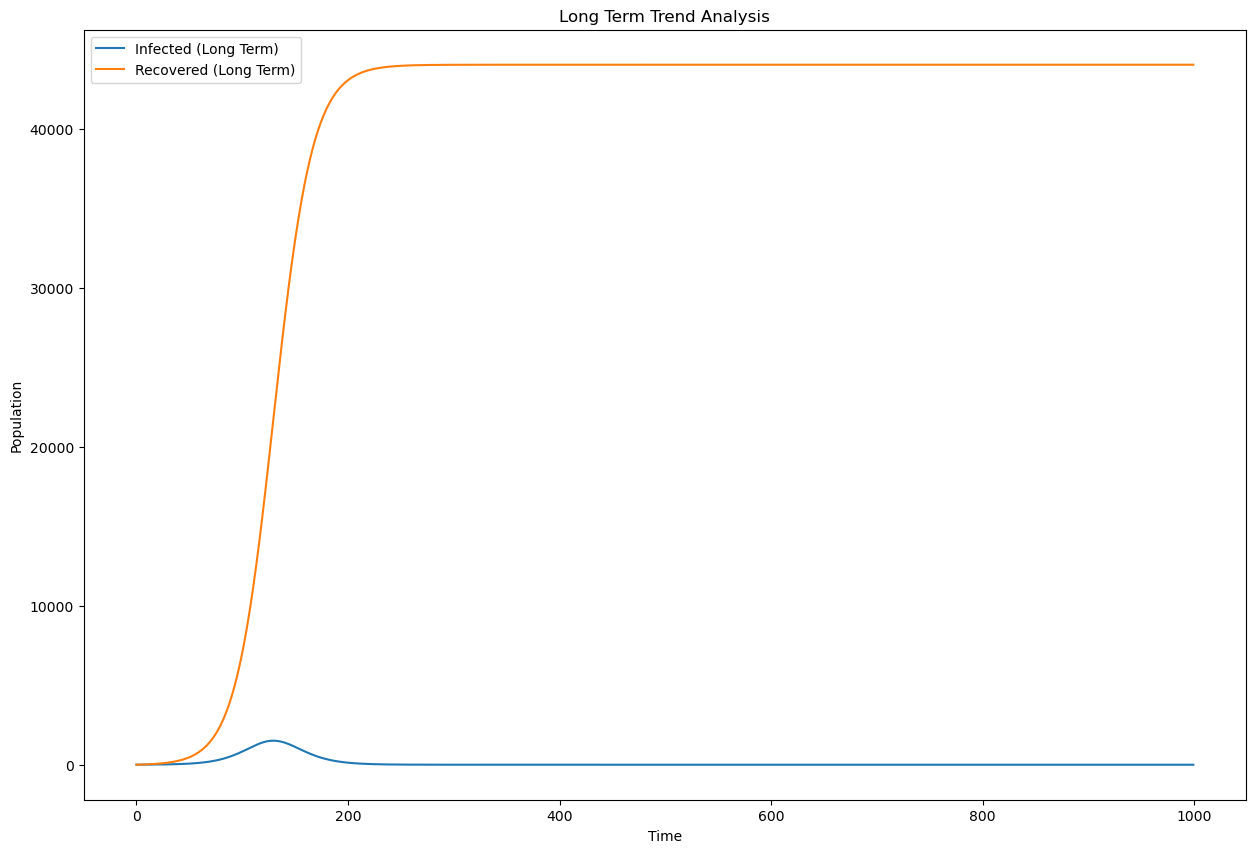

Equilibrium Point: [ 9.40283475e+04  1.67242309e-17  4.34070713e-25 -9.48859163e+02]


In [15]:
#!/usr/bin/python
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from scipy.optimize import fsolve
predict_range = 250
s_0=99990
e_0=8
i_0=2
r_0=0
ratio=0.5

class Learner(object):
    def __init__(self, loss, predict_range, s_0, e_0,i_0, r_0):
        self.loss = loss
        self.predict_range = predict_range
        self.s_0 = s_0
        self.e_0 = e_0
        self.i_0 = i_0
        self.r_0 = r_0

    def load_confirmed(self):
        df = pd.read_csv('02_SZ_DailyCases.csv')
        df.set_index(["Date"], inplace=True)
        dff=df["cummulative confirmed cases"]
        return dff.T

    def load_exposed(self,ratio):
        df = pd.read_csv('02_SZ_DailyCases.csv')
        df.set_index(["Date"], inplace=True)
        dff=df["cummulative confirmed cases"]
        dfff=dff*ratio
        return dfff.T


    def load_recovered(self):
        df = pd.read_csv('02_SZ_DailyCases.csv')
        df.set_index(["Date"], inplace=True)
        dff = df["cummulative cured cases"]
        return dff.T

    def load_dead(self):
        df = pd.read_csv('02_SZ_DailyCases.csv')
        df.set_index(["Date"], inplace=True)
        dff = df["cummulative dead cases"]
        return dff.T

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, alpha, gamma, data, exposed, recovered, death, s_0, e_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)

        def SEIR(t, y):
            S = y[0]
            E = y[1]
            I = y[2]
            R = y[3]
            return [-beta * S * I, beta * S * I - alpha* E, alpha* E- gamma * I, gamma * I]

        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_exposed = np.concatenate((exposed.values, [None] * (size - len(exposed.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        return new_index, extended_actual, extended_exposed, extended_recovered, extended_death, solve_ivp(SEIR,[0, size],
                                                                                         [s_0, e_0,i_0, r_0],
                                                                                         t_eval=np.arange(0, size, 1))

    def train(self):
        recovered = self.load_recovered()
        exposed = self.load_exposed(ratio)
        death = self.load_dead()
        data = (self.load_confirmed() - exposed - recovered - death)#易感人数

        optimal = minimize(loss, [0.001, 0.001, 0.001], args=(data, exposed, recovered, self.s_0, self.e_0, self.i_0, self.r_0),
                           method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4), (0.00000001, 0.4)])
        print(optimal)
        beta, alpha, gamma = optimal.x
        new_index, extended_actual, extended_exposed, extended_recovered, extended_death, prediction = self.predict(beta, alpha, gamma, data, exposed, recovered, death,

                                                                                                  self.s_0, self.e_0,self.i_0,
                                                                                                  self.r_0)
        df = pd.DataFrame(
            {'Infected data': extended_actual, 'Recovered data': extended_recovered, 'Death data': extended_death,
             'Susceptible': prediction.y[0], 'Exposed': prediction.y[1], 'Infected': prediction.y[2], 'Recovered': prediction.y[3]},
            index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        #ax.set_title(self.country)
        df.plot(ax=ax)
        print(f" beta={beta:.8f}, alpha={alpha:.8f}, gamma={gamma:.8f}, r_0:{(beta / gamma):.8f}")
        fig.show()
        print(df)

    def analyze_asymptotic_behavior(self, beta, alpha, gamma, s_0, e_0, i_0, r_0):
        def SEIR(t, y):
            S = y[0]
            E = y[1]
            I = y[2]
            R = y[3]
            return [-beta * S * I, beta * S * I - alpha * E, alpha * E - gamma * I, gamma * I]

        # 使用 solve_ivp 获取长期趋势
        long_term_solution = solve_ivp(SEIR, [0, 1000], [s_0, e_0, i_0, r_0], t_eval=np.arange(0, 1000, 1))

        # 绘制长期趋势
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.plot(long_term_solution.t, long_term_solution.y[2], label='Infected (Long Term)')
        ax.plot(long_term_solution.t, long_term_solution.y[3], label='Recovered (Long Term)')
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        ax.legend()
        ax.set_title('Long Term Trend Analysis')
        plt.show()

    def analyze_equilibrium(self, beta, alpha, gamma, s_0, e_0, i_0, r_0):
        def find_equilibrium_point():
            def equations(y, beta, alpha, gamma):
                S, E, I, R = y
                return [-beta * S * I, beta * S * I - alpha * E, alpha * E - gamma * I, gamma * I]

            # 初始猜测平衡点
            initial_guess = [s_0, e_0, i_0, r_0]
            equilibrium = fsolve(equations, initial_guess, args=(beta, alpha, gamma))
            return equilibrium

        equilibrium_point = find_equilibrium_point()

        print(f"Equilibrium Point: {equilibrium_point}")

    def train_and_analyze(self):
        recovered = self.load_recovered()
        exposed = self.load_exposed(ratio)
        death = self.load_dead()
        data = (self.load_confirmed() - exposed - recovered - death)

        optimal = minimize(loss, [0.001, 0.001, 0.001], args=(data, exposed, recovered, self.s_0, self.e_0, self.i_0, self.r_0),
                           method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4), (0.00000001, 0.4)])

        beta, alpha, gamma = optimal.x
        self.analyze_asymptotic_behavior(beta, alpha, gamma, self.s_0, self.e_0, self.i_0, self.r_0)
        self.analyze_equilibrium(beta, alpha, gamma, self.s_0, self.e_0, self.i_0, self.r_0)


def loss(point, data, exposed, recovered, s_0, e_0, i_0, r_0):
    size = len(data)
    beta, alpha, gamma = point

    def SEIR(t, y):
        S = y[0]
        E = y[1]
        I = y[2]
        R = y[3]
        return [-beta * S * I, beta * S * I - alpha * E, alpha * E - gamma * I, gamma * I]

    solution = solve_ivp(SEIR, [0, size], [s_0, e_0, i_0, r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data) ** 2))
    l2 = np.sqrt(np.mean((solution.y[2] - exposed) ** 2))
    l3 = np.sqrt(np.mean((solution.y[3] - recovered) ** 2))
    a1 = 0.1
    a2 = 0.1
    return a1 * l1 + a2 * l2 + (1 - a1 - a2) * l3


def main():
    learner = Learner(loss, predict_range, s_0, e_0, i_0, r_0)
    learner.train_and_analyze()


if __name__ == '__main__':
    main()